C:\Users\HerbyHerb\AppData\Local\Temp\ipykernel_10092\2863842235.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


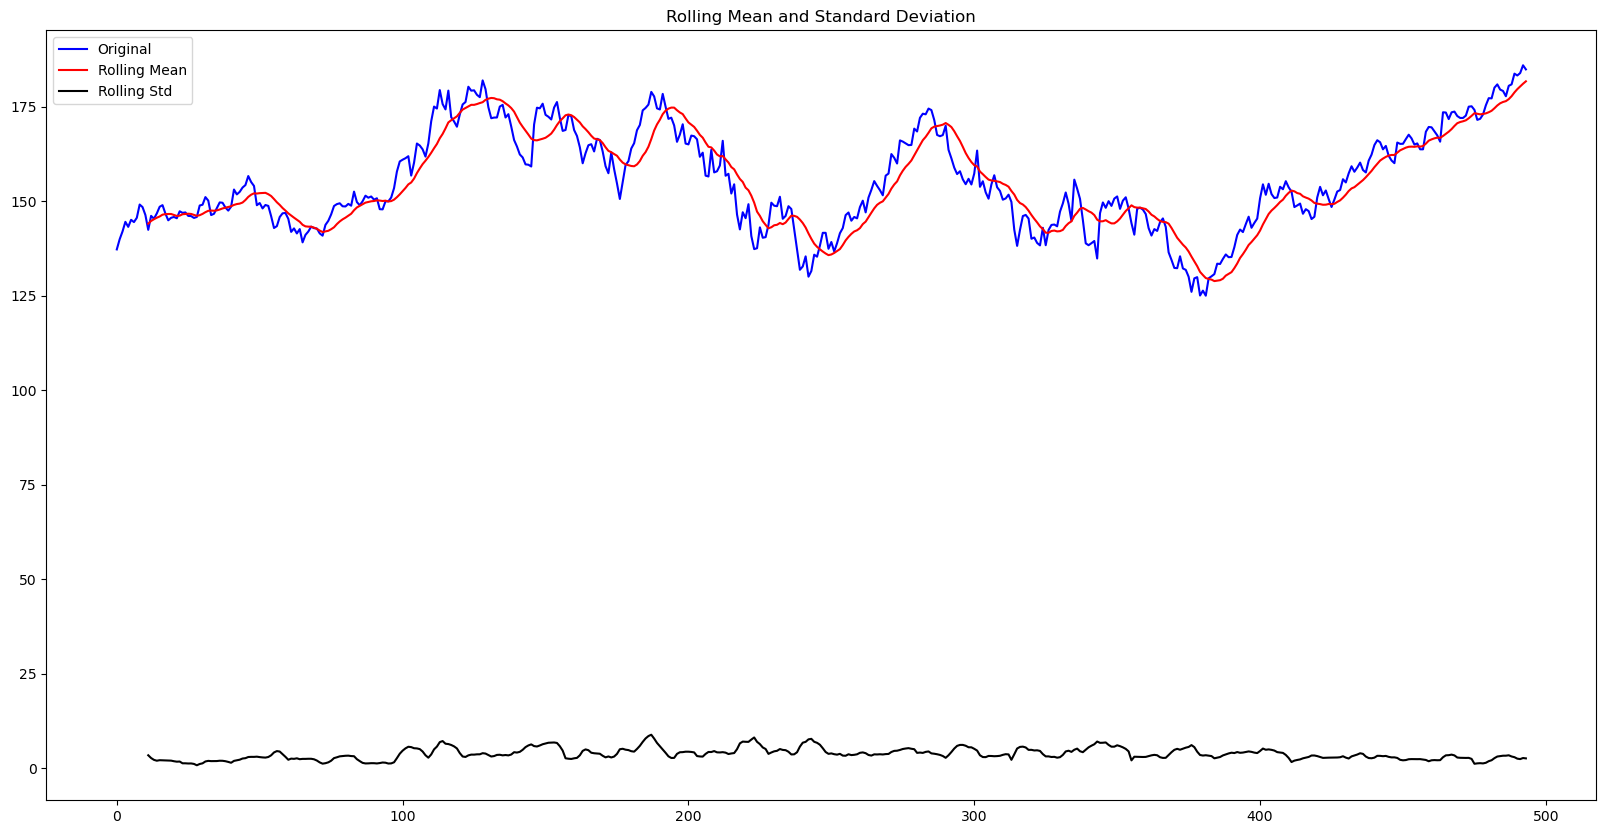

Results of Dickey-Fuller test
Test Statistics                 -2.110078
p-value                          0.240481
No. of lags used                 0.000000
Number of observations used    493.000000
Critical value (1%)             -3.443684
Critical value (5%)             -2.867420
Critical value (10%)            -2.569902
dtype: float64


In [3]:
import pyodbc
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Verbindungsstring zur MS SQL-Datenbank
conn_str = (
    r'Driver={SQL Server};'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur MS SQL-Datenbank herstellen und Daten abrufen
connection = pyodbc.connect(conn_str)
query = "SELECT timestamp, o, c, h, l FROM stock_data ORDER BY timestamp"
data = pd.read_sql(query, connection)

def test_adf(timeseries):
    moving_average = timeseries.rolling(12).mean()
    moving_std = timeseries.rolling(12).std()

    plt.figure(figsize=(20, 10))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(moving_average, color="red", label='Rolling Mean')
    plt.plot(moving_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of Dickey-Fuller test")
    adft = adfuller(timeseries, autolag="AIC")
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    
    for key, value in adft[4].items():
        output['Critical value (%s) ' % key] = value

    print(output)

test_adf(data['c'])


<Figure size 1600x900 with 0 Axes>

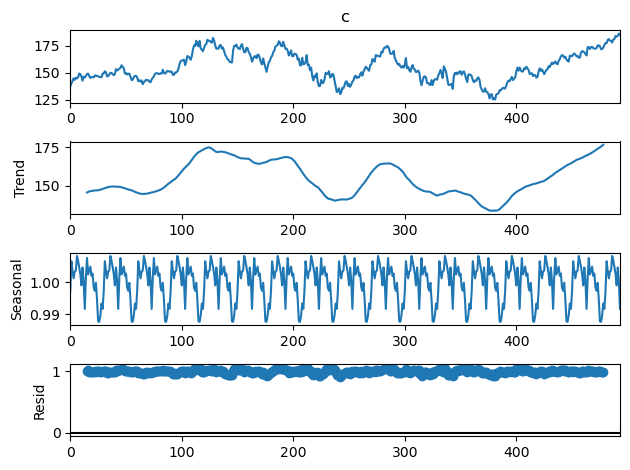

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

result = seasonal_decompose(data['c'], model='multiplicative', period=30)
fig = plt.figure()
result.plot()
fig.set_size_inches(16, 9)
plt.show()



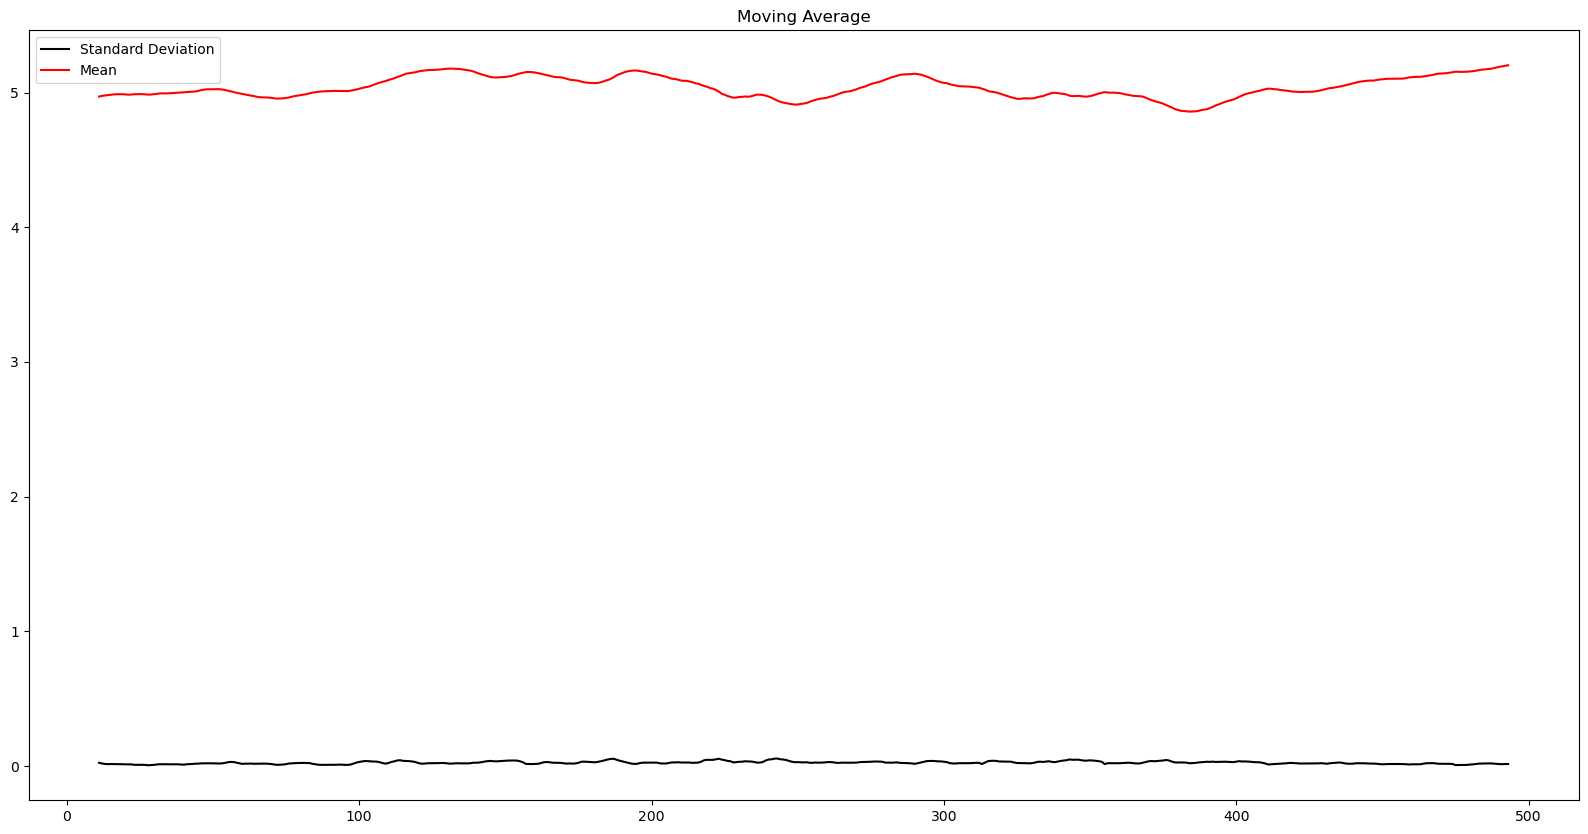

In [7]:
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

data_adj_close_log = np.log(data['c'])
moving_average = data_adj_close_log.rolling(12).mean()
std_dev = data_adj_close_log.rolling(12).std()

plt.plot(std_dev, color='black', label='Standard Deviation')
plt.plot(moving_average, color='red', label='Mean')
plt.legend()
plt.title('Moving Average')
plt.show()


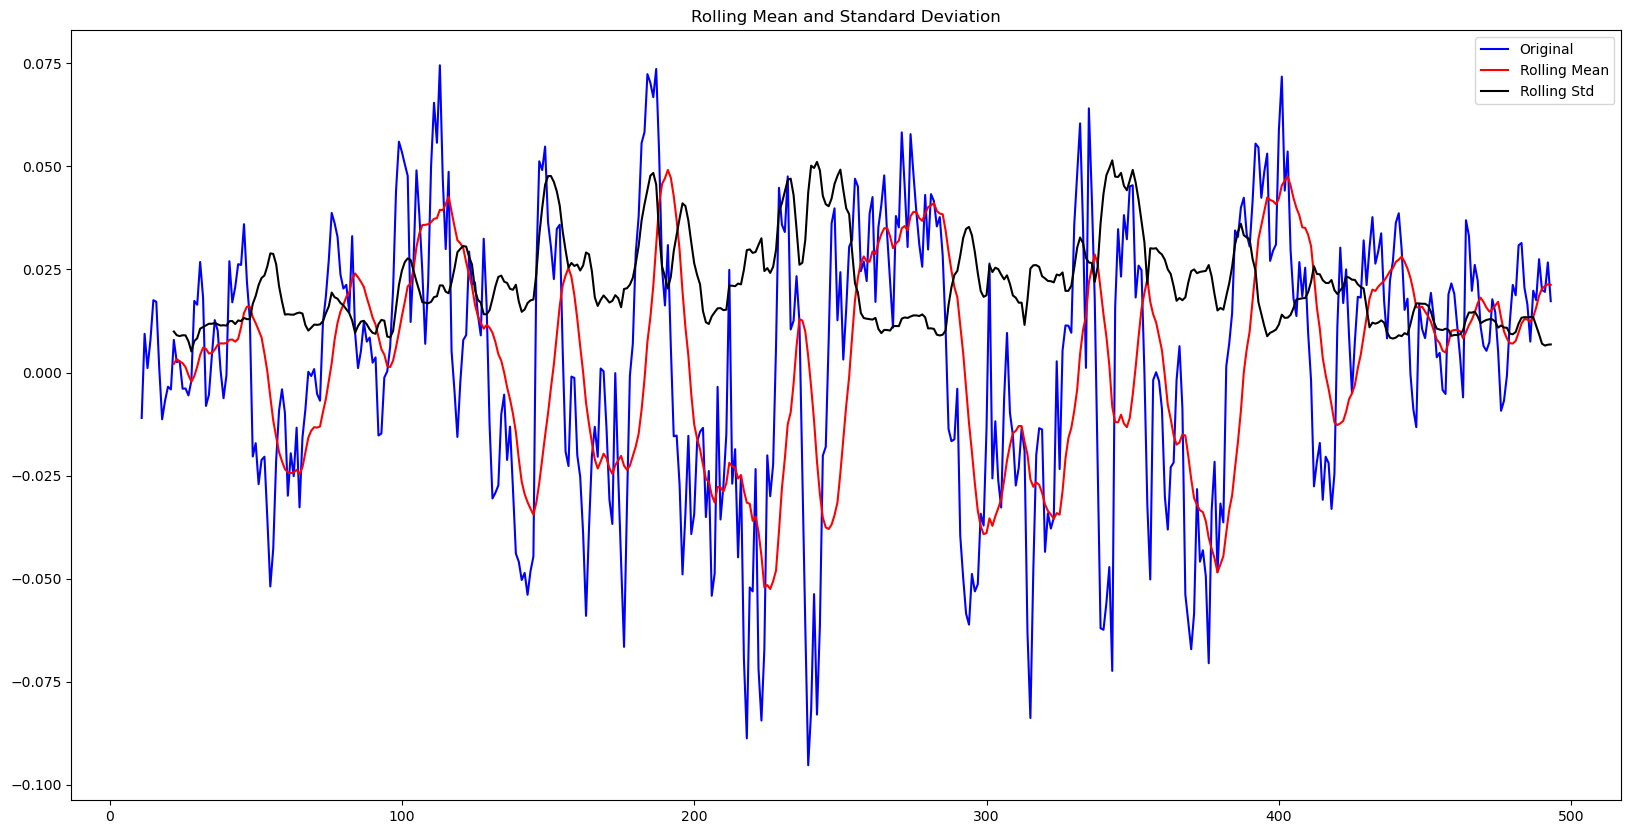

Results of Dickey-Fuller test
Test Statistics               -6.410983e+00
p-value                        1.891151e-08
No. of lags used               1.000000e+00
Number of observations used    4.810000e+02
Critical value (1%)           -3.444018e+00
Critical value (5%)           -2.867568e+00
Critical value (10%)          -2.569980e+00
dtype: float64


In [8]:
data_log_minus_mean = data_adj_close_log - moving_average  # Eine Technik, um die Zeitreihe stationär zu machen
data_log_minus_mean.dropna(inplace=True)
test_adf(data_log_minus_mean)


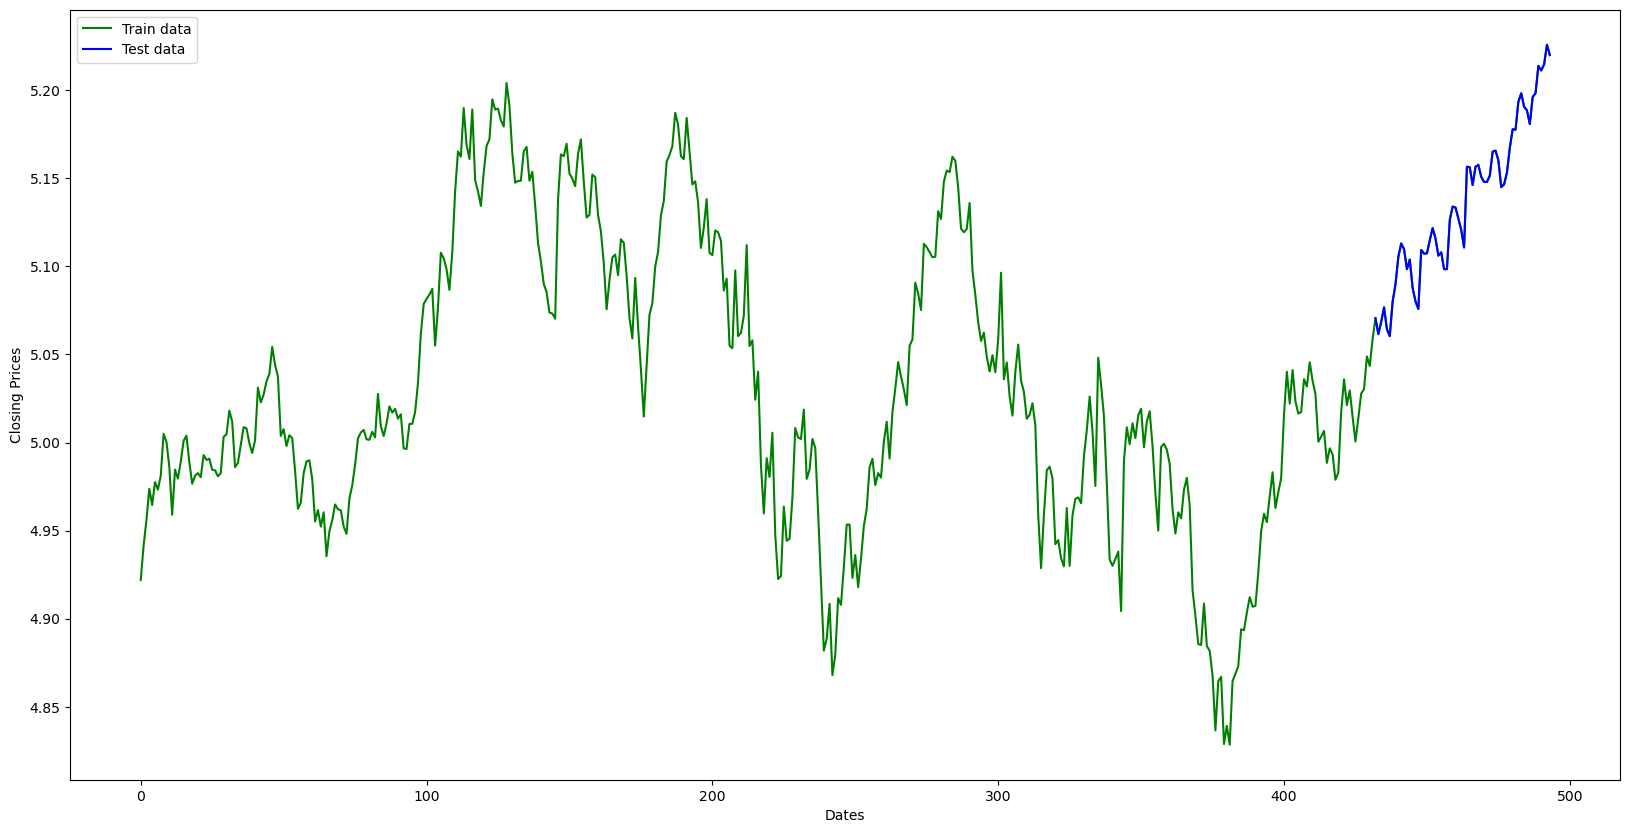

In [9]:
train_data = data_adj_close_log[:int(len(data_adj_close_log)*0.875)]
test_data = data_adj_close_log[int(len(data_adj_close_log)*0.875):]

plt.figure(figsize=(20, 10))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data_adj_close_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()



In [11]:
from pmdarima import auto_arima

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                             test='adf',
                             max_p=7, max_q=7, m=1,
                             d=None,
                             seasonal=False,
                             start_P=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2161.551, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2159.597, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2159.596, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2163.439, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2158.562, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.926 seconds


In [21]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(0, 1, 0))
fitted = model.fit()



C:\Users\HerbyHerb\.conda\envs\tf_new\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
test_data.shape

(62,)

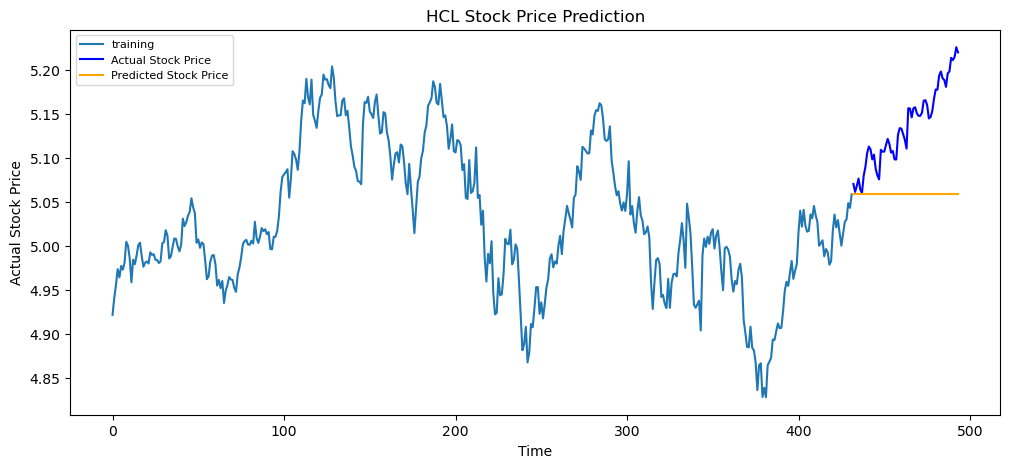

In [24]:
fc = fitted.forecast(62, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')

plt.title('HCL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [25]:
import math
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data, fc)
print('MSE: ' + str(mse))

mae = mean_absolute_error(test_data, fc)
print('MAE: ' + str(mae))

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ' + str(rmse))

mape = np.mean(np.abs(fc - test_data) / np.abs(test_data))
print('MAPE: ' + str(mape))


MSE: 0.007963276393824234
MAE: 0.0774423539487811
RMSE: 0.0892371917634359
MAPE: 0.015004364081632816
